## Chapter 8
### Categorical Encoding with the Housing Price & Titanic Dataset
This notebook is a companion to the book XGBoost for Regression Predictive Modeling and Time Series Analysis. This chapter is a hands on guide for various categorical encoding techniques designed to give you hands-on experience with various categorical encoding techniques

### Citing some the sources 

- [kaggle Houysing price prediction](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/) - Kaggle kernel
- [Titanic dataset](https://www.openml.org/search?type=data&status=active&id=40945&sort=runs) - OpenML Datasets

Citation for the housing price dataset: `Dean De Cock(2011) Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project, Journal of Statistics Education, 19:3, DOI: 10.1080/10691898.2011.11889627.`

### In this notebook we walk through the following encoding techniques for categorical data:

- One Hot Encoding
- One Hot encoding with Frequent Categories
- Count or Frequency Encoding
- Integer Encoding
- Ordered Integer Encoding
- Mean Encoding
- Probability Ration Encoding
- Weight of Evidence Encoding
- Engineering Rare Categories

#### One Hot Encoding

One hot encoding is a method used to transform categorical variables into binary vectors. This technique creates boolean columns for each category, assigning a value of 1 if the observation matches the category and 0 otherwise. For instance, the variable "Gender" with categories 'female' and 'male' can be encoded into "female" (1 if female, 0 otherwise) and "male" (1 if male, 0 otherwise). Similarly, for the variable "Color" with values 'red', 'blue', and 'green', we create three binary variables: "red", "blue", and "green".

To minimize redundancy, we often use \(k-1\) binary variables for a categorical variable with \(k\) categories. For example, "Color" can be represented by "red" and "blue", with "green" implied when both are 0. This approach reduces the feature space while retaining all the information. However, encoding into \(k\) variables is sometimes necessary for tree-based algorithms or feature selection processes.

One hot encoding is simple and effective but can expand the feature space, which might introduce redundancy and complicate model training and interpretation.


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Sample data
data = {
    'Gender': ['male', 'female', 'female', 'male'],
    'Color': ['red', 'blue', 'green', 'red']
}
df = pd.DataFrame(data)

# Split data
X_train, X_test = train_test_split(df, test_size=0.5, random_state=0)

# Pandas one hot encoding
pd_encoded = pd.get_dummies(X_train, drop_first=True)
print("Pandas One Hot Encoding:\n", pd_encoded)

# Scikit-learn one hot encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(X_train)
sk_encoded = encoder.transform(X_train)
sk_encoded_df = pd.DataFrame(sk_encoded, columns=encoder.get_feature_names_out())
print("Scikit-learn One Hot Encoding:\n", sk_encoded_df)

Pandas One Hot Encoding:
    Gender_male  Color_red
1        False      False
0         True       True
Scikit-learn One Hot Encoding:
    Gender_male  Color_red
0          0.0        0.0
1          1.0        1.0


In this example, we demonstrate one hot encoding using pandas and Scikit-learn. Each method effectively encodes categorical variables while highlighting the simplicity and potential redundancy issues of one hot encoding.


#### One Hot Encoding of Frequent Categories
High cardinality and rare labels in categorical variables can lead to overfitting or difficulties in scoring unseen categories. One hot encoding of the most frequent categories mitigates these issues by creating binary variables for only the top categories, effectively grouping less common categories into a single category.

This approach avoids dramatically expanding the feature space and is straightforward to implement. It is particularly useful in situations where a few categories dominate. While it may not capture the full information of less common labels, it strikes a balance between simplicity and effectiveness.

Below is an example of one hot encoding for the most frequent categories using pandas and Scikit-learn.

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Sample data
data = {
    'Neighborhood': ['OldTown', 'CollgCr', 'Somerst', 'NAmes', 'OldTown', 'CollgCr', 'Edwards', 'NAmes', 'Edwards', 'OldTown'],
    'SalePrice': [200000, 250000, 190000, 300000, 210000, 230000, 180000, 320000, 190000, 215000]
}
df = pd.DataFrame(data)

# Separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['Neighborhood']], df['SalePrice'], test_size=0.5, random_state=0)

# Calculate top categories
def calculate_top_categories(df, variable, how_many=2):
    return [x for x in df[variable].value_counts().sort_values(ascending=False).head(how_many).index]

top_categories = calculate_top_categories(X_train, 'Neighborhood')

# One hot encode top categories
def one_hot_encode(train, test, variable, top_x_labels):
    for label in top_x_labels:
        train[variable + '_' + label] = (train[variable] == label).astype(int)
        test[variable + '_' + label] = (test[variable] == label).astype(int)
        
    return train, test

X_train_encoded, X_test_encoded = one_hot_encode(X_train, X_test, 'Neighborhood', top_categories)

print("Pandas One Hot Encoding of Frequent Categories:\n", X_train_encoded)

# Scikit-learn one hot encoding of top categories
encoder = OneHotEncoder(categories=[top_categories], sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[['Neighborhood']])

sk_encoded = encoder.transform(X_train[['Neighborhood']])
sk_encoded_df = pd.DataFrame(sk_encoded, columns=encoder.get_feature_names_out(['Neighborhood']))
print("Scikit-learn One Hot Encoding of Frequent Categories:\n", sk_encoded_df)


Pandas One Hot Encoding of Frequent Categories:
   Neighborhood  Neighborhood_NAmes  Neighborhood_Edwards
6      Edwards                   0                     1
7        NAmes                   1                     0
3        NAmes                   1                     0
0      OldTown                   0                     0
5      CollgCr                   0                     0
Scikit-learn One Hot Encoding of Frequent Categories:
    Neighborhood_NAmes  Neighborhood_Edwards
0                 0.0                   1.0
1                 1.0                   0.0
2                 1.0                   0.0
3                 0.0                   0.0
4                 0.0                   0.0


### Integer Encoding
Integer encoding replaces categories with unique integers, from 0 to 𝑛−1 where n is the number of distinct categories. This encoding method is straightforward and does not expand the feature space. While it does not capture any inherent relationships between categories, it allows for quick benchmarking of machine learning models and works well with tree-based models.

Below is an example of integer encoding using pandas and Scikit-learn.

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Sample data
data = {
    'Neighborhood': ['OldTown', 'CollgCr', 'Somerst', 'NAmes', 'OldTown', 'CollgCr', 'Edwards', 'NAmes', 'Edwards', 'OldTown'],
    'SalePrice': [200000, 250000, 190000, 300000, 210000, 230000, 180000, 320000, 190000, 215000]
}
df = pd.DataFrame(data)

# Separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['Neighborhood']], df['SalePrice'], test_size=0.5, random_state=0)

# Integer encoding with pandas
le = LabelEncoder()
X_train['Neighborhood_enc'] = le.fit_transform(X_train['Neighborhood'])

# Handle unseen labels in the test set by assigning -1
X_test['Neighborhood_enc'] = X_test['Neighborhood'].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

print("Pandas Integer Encoding:\n", X_train)
print("Pandas Integer Encoding Test Set:\n", X_test)

# Integer encoding with Scikit-learn for multiple columns
from collections import defaultdict

# Create a dictionary to hold label encoders for each column
d = defaultdict(LabelEncoder)

# Apply label encoder to each column
X_train['Neighborhood_enc'] = d['Neighborhood'].fit_transform(X_train['Neighborhood'])
X_test['Neighborhood_enc'] = X_test['Neighborhood'].apply(lambda x: d['Neighborhood'].transform([x])[0] if x in d['Neighborhood'].classes_ else -1)

print("Scikit-learn Integer Encoding:\n", X_train)
print("Scikit-learn Integer Encoding Test Set:\n", X_test)


Pandas Integer Encoding:
   Neighborhood  Neighborhood_enc
6      Edwards                 1
7        NAmes                 2
3        NAmes                 2
0      OldTown                 3
5      CollgCr                 0
Pandas Integer Encoding Test Set:
   Neighborhood  Neighborhood_enc
2      Somerst                -1
8      Edwards                 1
4      OldTown                 3
9      OldTown                 3
1      CollgCr                 0
Scikit-learn Integer Encoding:
   Neighborhood  Neighborhood_enc
6      Edwards                 1
7        NAmes                 2
3        NAmes                 2
0      OldTown                 3
5      CollgCr                 0
Scikit-learn Integer Encoding Test Set:
   Neighborhood  Neighborhood_enc
2      Somerst                -1
8      Edwards                 1
4      OldTown                 3
9      OldTown                 3
1      CollgCr                 0


In this example, we demonstrate integer encoding using pandas and Scikit-learn. Integer encoding replaces categories with unique integers, making it simple and effective for non-linear models.


### Count or Frequency Encoding
Count or frequency encoding replaces categories with their count or frequency in the dataset. For example, if 10 out of 100 observations are 'blue', 'blue' is replaced with 10 in count encoding or 0.1 in frequency encoding. This technique captures the representation of each label, making it simple and effective without expanding the feature space.

However, it can lose valuable information if different categories have the same count or frequency. For instance, if both 'blue' and 'red' appear 10 times, they will be encoded identically.

Below is an example of count and frequency encoding using pandas.

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Sample data
data = {
    'Neighborhood': ['OldTown', 'CollgCr', 'Somerst', 'NAmes', 'OldTown', 'CollgCr', 'Edwards', 'NAmes', 'Edwards', 'OldTown'],
    'Exterior1st': ['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'VinylSd', 'HdBoard', 'MetalSd', 'HdBoard', 'VinylSd'],
    'SalePrice': [200000, 250000, 190000, 300000, 210000, 230000, 180000, 320000, 190000, 215000]
}
df = pd.DataFrame(data)

# Separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['Neighborhood', 'Exterior1st']], df['SalePrice'], test_size=0.5, random_state=0)

# Count encoding with pandas
count_map = X_train['Neighborhood'].value_counts().to_dict()
X_train['Neighborhood_count'] = X_train['Neighborhood'].map(count_map)
X_test['Neighborhood_count'] = X_test['Neighborhood'].map(count_map).fillna(0)  # Handle unseen labels

print("Pandas Count Encoding:\n", X_train)

# Frequency encoding with pandas
frequency_map = (X_train['Exterior1st'].value_counts() / len(X_train)).to_dict()
X_train['Exterior1st_freq'] = X_train['Exterior1st'].map(frequency_map)
X_test['Exterior1st_freq'] = X_test['Exterior1st'].map(frequency_map).fillna(0)  # Handle unseen labels

print("Pandas Frequency Encoding:\n", X_train)


Pandas Count Encoding:
   Neighborhood Exterior1st  Neighborhood_count
6      Edwards     HdBoard                   1
7        NAmes     MetalSd                   2
3        NAmes     HdBoard                   2
0      OldTown     VinylSd                   1
5      CollgCr     VinylSd                   1
Pandas Frequency Encoding:
   Neighborhood Exterior1st  Neighborhood_count  Exterior1st_freq
6      Edwards     HdBoard                   1               0.4
7        NAmes     MetalSd                   2               0.2
3        NAmes     HdBoard                   2               0.4
0      OldTown     VinylSd                   1               0.4
5      CollgCr     VinylSd                   1               0.4


In this example, we demonstrate count and frequency encoding using pandas. These methods replace categories with their respective counts or frequencies, making them simple and effective for many applications.

### Ordered Integer Encoding
Ordered integer encoding replaces categories with integers based on the order of a target variable, often the mean of the target variable within each category. This method ensures a monotonic relationship between the encoded variable and the target, which can be beneficial for linear models.

Below is an example of ordered integer encoding using pandas.

Ordered Integer Encoding with Pandas:
   Neighborhood Exterior1st  SalePrice  Neighborhood_enc  Exterior1st_enc
6      Edwards     HdBoard     180000                 0                1
7        NAmes     MetalSd     320000                 3                2
3        NAmes     HdBoard     300000                 3                1
0      OldTown     VinylSd     200000                 1                0
5      CollgCr     VinylSd     230000                 2                0


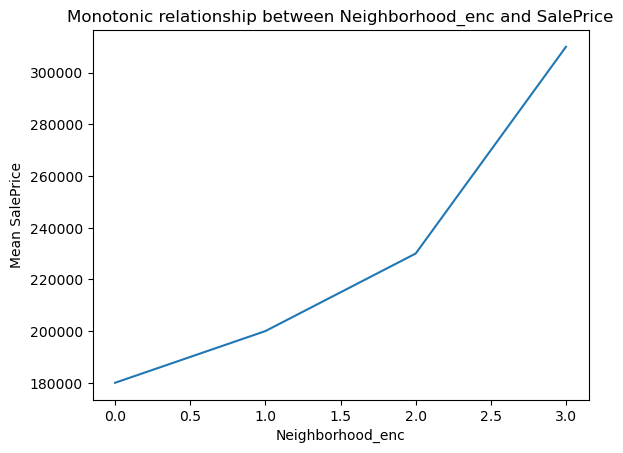

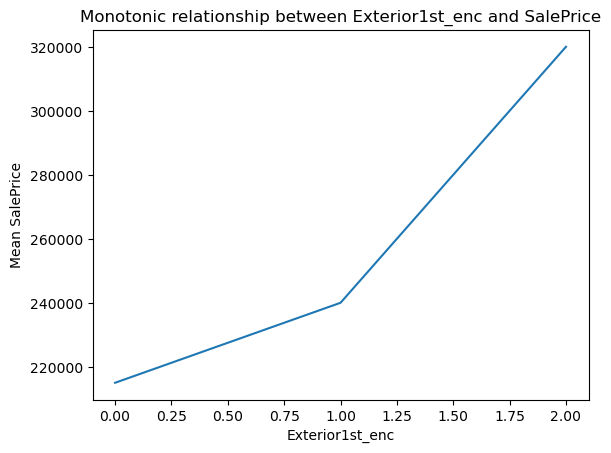

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Sample data
data = {
    'Neighborhood': ['OldTown', 'CollgCr', 'Somerst', 'NAmes', 'OldTown', 'CollgCr', 'Edwards', 'NAmes', 'Edwards', 'OldTown'],
    'Exterior1st': ['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'VinylSd', 'HdBoard', 'MetalSd', 'HdBoard', 'VinylSd'],
    'SalePrice': [200000, 250000, 190000, 300000, 210000, 230000, 180000, 320000, 190000, 215000]
}
df = pd.DataFrame(data)

# Separate into training and testing sets
X_train, X_test = train_test_split(df, test_size=0.5, random_state=0)

# Function to calculate mean target value for each category and create mapping
def find_category_mappings(df, variable, target):
    ordered_labels = df.groupby([variable])[target].mean().sort_values().index
    return {k: i for i, k in enumerate(ordered_labels, 0)}

# Function to apply the mapping
def integer_encode(train, test, variable, ordinal_mapping):
    train[variable + '_enc'] = train[variable].map(ordinal_mapping)
    test[variable + '_enc'] = test[variable].map(ordinal_mapping)
    return train, test

# Apply ordered integer encoding
mappings = find_category_mappings(X_train, 'Neighborhood', 'SalePrice')
X_train, X_test = integer_encode(X_train, X_test, 'Neighborhood', mappings)

mappings = find_category_mappings(X_train, 'Exterior1st', 'SalePrice')
X_train, X_test = integer_encode(X_train, X_test, 'Exterior1st', mappings)

print("Ordered Integer Encoding with Pandas:\n", X_train.head())

# Let's visualize the monotonic relationship
for var in ['Neighborhood_enc', 'Exterior1st_enc']:
    fig = plt.figure()
    X_train.groupby([var])['SalePrice'].mean().plot()
    plt.title(f'Monotonic relationship between {var} and SalePrice')
    plt.ylabel('Mean SalePrice')
    plt.show()


In this example, we demonstrate ordered integer encoding using pandas. This method replaces categories with integers based on the order of the mean target value within each category, ensuring a monotonic relationship that is beneficial for linear models.


### Mean Encoding
Mean encoding replaces categories with the mean of the target variable within each category. This method ensures a relationship between the encoded variable and the target, which can be beneficial for linear models.

Below is an example of mean encoding using pandas.

Mean Encoding with Pandas:
   Neighborhood Exterior1st  SalePrice  Neighborhood_mean_enc  \
6      Edwards     HdBoard     180000               180000.0   
7        NAmes     MetalSd     320000               310000.0   
3        NAmes     HdBoard     300000               310000.0   
0      OldTown     VinylSd     200000               200000.0   
5      CollgCr     VinylSd     230000               230000.0   

   Exterior1st_mean_enc  
6              240000.0  
7              320000.0  
3              240000.0  
0              215000.0  
5              215000.0  


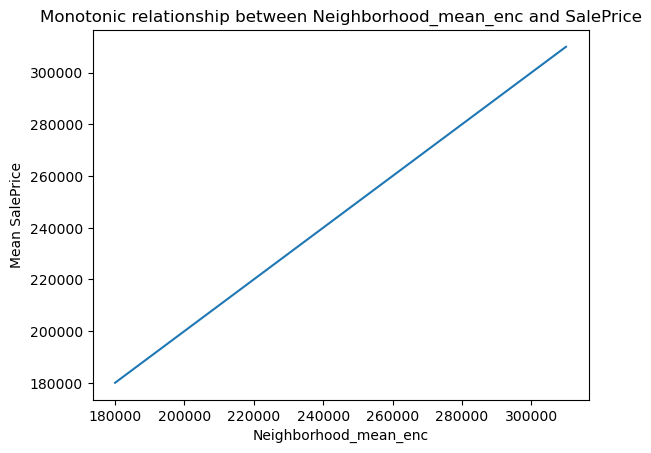

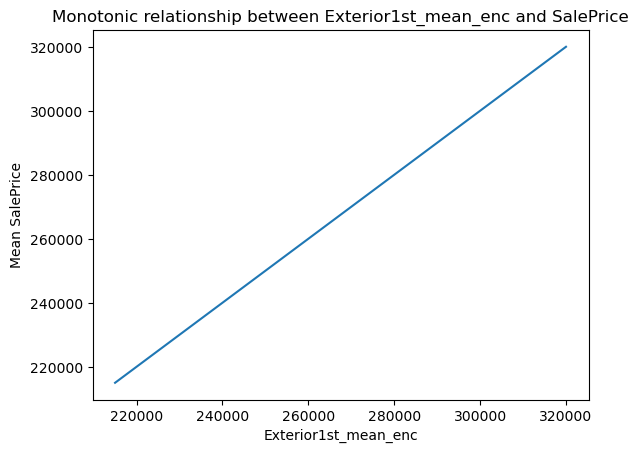

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Sample data
data = {
    'Neighborhood': ['OldTown', 'CollgCr', 'Somerst', 'NAmes', 'OldTown', 'CollgCr', 'Edwards', 'NAmes', 'Edwards', 'OldTown'],
    'Exterior1st': ['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'VinylSd', 'HdBoard', 'MetalSd', 'HdBoard', 'VinylSd'],
    'SalePrice': [200000, 250000, 190000, 300000, 210000, 230000, 180000, 320000, 190000, 215000]
}
df = pd.DataFrame(data)

# Separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df, df['SalePrice'], test_size=0.5, random_state=0)

# Function to calculate mean target value for each category and create mapping
def find_category_mappings(df, variable, target):
    return df.groupby([variable])[target].mean().to_dict()

# Function to apply the mapping
def mean_encode(train, test, variable, ordinal_mapping):
    train[variable + '_mean_enc'] = train[variable].map(ordinal_mapping)
    test[variable + '_mean_enc'] = test[variable].map(ordinal_mapping)
    return train, test

# Apply mean encoding
mappings = find_category_mappings(X_train, 'Neighborhood', 'SalePrice')
X_train, X_test = mean_encode(X_train, X_test, 'Neighborhood', mappings)

mappings = find_category_mappings(X_train, 'Exterior1st', 'SalePrice')
X_train, X_test = mean_encode(X_train, X_test, 'Exterior1st', mappings)

print("Mean Encoding with Pandas:\n", X_train.head())

# Let's visualize the monotonic relationship
for var in ['Neighborhood_mean_enc', 'Exterior1st_mean_enc']:
    fig = plt.figure()
    X_train.groupby([var])['SalePrice'].mean().plot()
    plt.title(f'Monotonic relationship between {var} and SalePrice')
    plt.ylabel('Mean SalePrice')
    plt.show()


In this example, we demonstrate mean encoding using pandas. This method replaces categories with the mean of the target value within each category, ensuring a relationship that can be beneficial for linear models.

### Probability Ratio Encoding

Probability ratio encoding replaces categories with the ratio of the probability of the target being 1 to the probability of the target being 0 for each category. This method captures information within the category and creates a monotonic relationship between the variable and the target, making it suitable for linear models.

Below is an example of probability ratio encoding using pandas.

Probability Ratio Encoding with Pandas:
   Neighborhood Exterior1st  SalePrice  HighPrice  Neighborhood_ratio_enc  \
6      Edwards     HdBoard     180000          0                     0.5   
7        NAmes     MetalSd     320000          1                     2.0   
3        NAmes     HdBoard     300000          1                     2.0   
0      OldTown     VinylSd     200000          0                     0.5   
5      CollgCr     VinylSd     230000          1                     2.0   

   Exterior1st_ratio_enc  
6                    1.0  
7                    2.0  
3                    1.0  
0                    1.0  
5                    1.0  


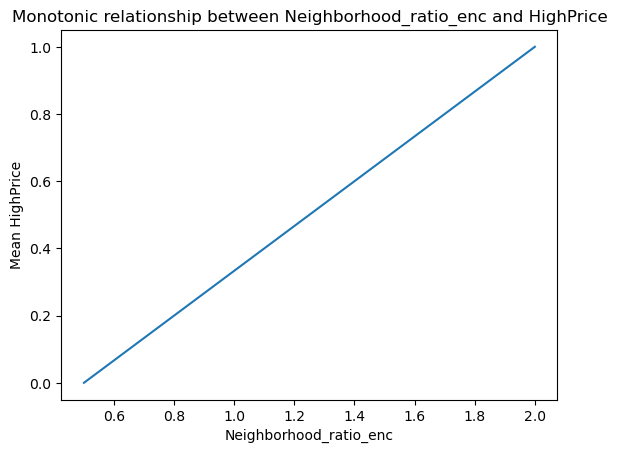

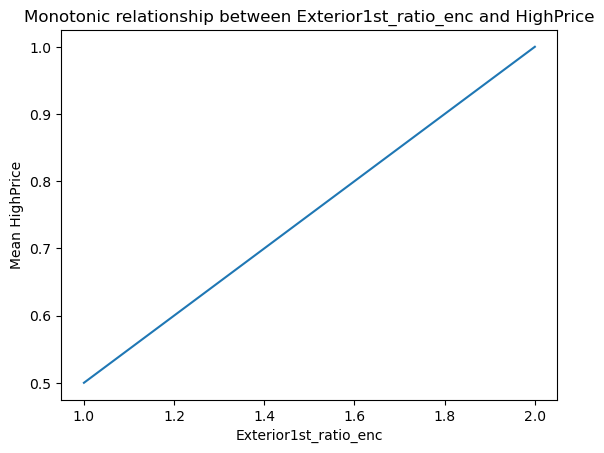

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Sample data
data = {
    'Neighborhood': ['OldTown', 'CollgCr', 'Somerst', 'NAmes', 'OldTown', 'CollgCr', 'Edwards', 'NAmes', 'Edwards', 'OldTown'],
    'Exterior1st': ['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'VinylSd', 'HdBoard', 'MetalSd', 'HdBoard', 'VinylSd'],
    'SalePrice': [200000, 250000, 190000, 300000, 210000, 230000, 180000, 320000, 190000, 215000]
}
df = pd.DataFrame(data)

# Binarize target for the purpose of this demonstration
df['HighPrice'] = (df['SalePrice'] > 220000).astype(int)

# Separate into training and testing sets
X_train, X_test = train_test_split(df, test_size=0.5, random_state=0)

# Function to calculate probability ratio for each category with smoothing
def find_category_mappings(df, variable, target, smoothing=1):
    tmp = pd.DataFrame(df.groupby([variable])[target].mean())
    tmp['non-target'] = 1 - tmp[target]
    tmp['ratio'] = (tmp[target] + smoothing) / (tmp['non-target'] + smoothing)
    return tmp['ratio'].to_dict()

# Function to apply the mapping
def ratio_encode(train, test, variable, ordinal_mapping):
    train[variable + '_ratio_enc'] = train[variable].map(ordinal_mapping)
    test[variable + '_ratio_enc'] = test[variable].map(ordinal_mapping)
    return train, test

# Apply probability ratio encoding
mappings = find_category_mappings(X_train, 'Neighborhood', 'HighPrice')
X_train, X_test = ratio_encode(X_train, X_test, 'Neighborhood', mappings)

mappings = find_category_mappings(X_train, 'Exterior1st', 'HighPrice')
X_train, X_test = ratio_encode(X_train, X_test, 'Exterior1st', mappings)

print("Probability Ratio Encoding with Pandas:\n", X_train.head())

# Let's visualize the monotonic relationship
for var in ['Neighborhood_ratio_enc', 'Exterior1st_ratio_enc']:
    plt.figure()
    X_train.groupby([var])['HighPrice'].mean().plot()
    plt.title(f'Monotonic relationship between {var} and HighPrice')
    plt.ylabel('Mean HighPrice')
    plt.xlabel(var)
    plt.show()


This updated example includes smoothing to avoid division by zero, ensuring that the probability ratio encoding works correctly and provides meaningful values for all categories. The visualization should now accurately reflect the monotonic relationship between the encoded variables and the target variable.

### Weight of Evidence (WoE) Encoding
Weight of Evidence (WoE) encoding was developed primarily for the credit and financial industries to help build predictive models for evaluating the risk of loan default. WoE measures the "strength” of a grouping technique to separate good and bad risk. WoE is well suited for Logistic Regression because it creates a monotonic relationship between the target and the independent variables and orders the categories on a "logistic" scale.

Below is an example of Weight of Evidence encoding using pandas.

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = {
    'Neighborhood': ['OldTown', 'CollgCr', 'Somerst', 'NAmes', 'OldTown', 'CollgCr', 'Edwards', 'NAmes', 'Edwards', 'OldTown'],
    'Exterior1st': ['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'VinylSd', 'HdBoard', 'MetalSd', 'HdBoard', 'VinylSd'],
    'SalePrice': [200000, 250000, 190000, 300000, 210000, 230000, 180000, 320000, 190000, 215000]
}
df = pd.DataFrame(data)

# Binarize target for the purpose of this demonstration
df['HighPrice'] = (df['SalePrice'] > 220000).astype(int)

# Separate into training and testing sets
X_train, X_test = train_test_split(df, test_size=0.5, random_state=0)

# Function to calculate WoE for each category with smoothing
def calculate_woe(df, variable, target, smoothing=0.5):
    tmp = pd.DataFrame(df.groupby([variable])[target].mean())
    tmp['non-target'] = 1 - tmp[target]
    tmp['woe'] = np.log((tmp[target] + smoothing) / (tmp['non-target'] + smoothing))
    return tmp['woe'].to_dict()

# Function to apply WoE mapping
def woe_encode(train, test, variable, woe_mapping):
    train[variable + '_woe_enc'] = train[variable].map(woe_mapping)
    test[variable + '_woe_enc'] = test[variable].map(woe_mapping)
    return train, test

# Apply WoE encoding
woe_mappings = calculate_woe(X_train, 'Neighborhood', 'HighPrice')
X_train, X_test = woe_encode(X_train, X_test, 'Neighborhood', woe_mappings)

woe_mappings


{'CollgCr': 1.0986122886681098,
 'Edwards': -1.0986122886681098,
 'NAmes': 1.0986122886681098,
 'OldTown': -1.0986122886681098}

In this example, we demonstrate Weight of Evidence (WoE) encoding using pandas. This method replaces categories with the log of the odds ratio of the target variable within each category, ensuring a monotonic relationship that is beneficial for logistic regression models.


### Engineering Rare Categories
Rare categories within categorical variables are those that appear infrequently in the dataset. These rare categories can cause issues during model training and scoring, as they may lead to overfitting or be unseen in the test set. To mitigate this, rare categories can be grouped under a new category called 'Rare' or 'Other'.

Below is an example of engineering rare categories using pandas. 

Engineering Rare Categories with Pandas:
   Neighborhood Exterior1st Exterior2nd
6      Edwards     HdBoard     HdBoard
7        NAmes     MetalSd     MetalSd
3        NAmes     HdBoard     HdBoard
0      OldTown     VinylSd     VinylSd
5      CollgCr     VinylSd     VinylSd


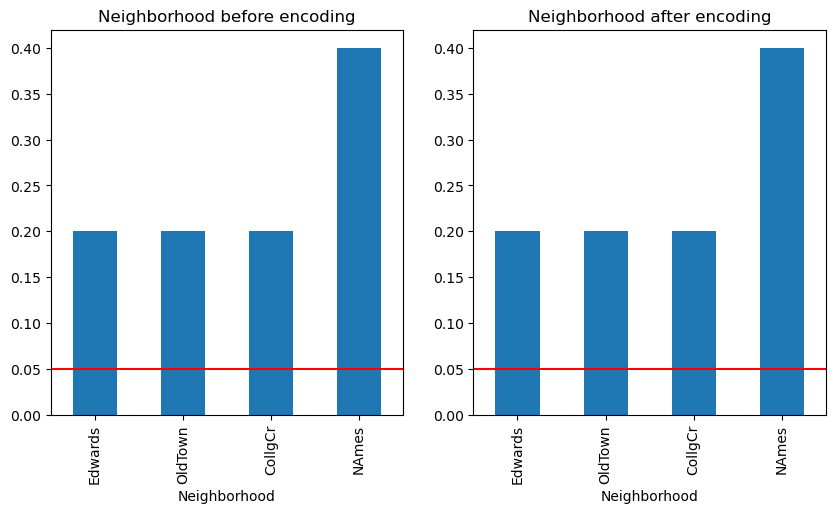

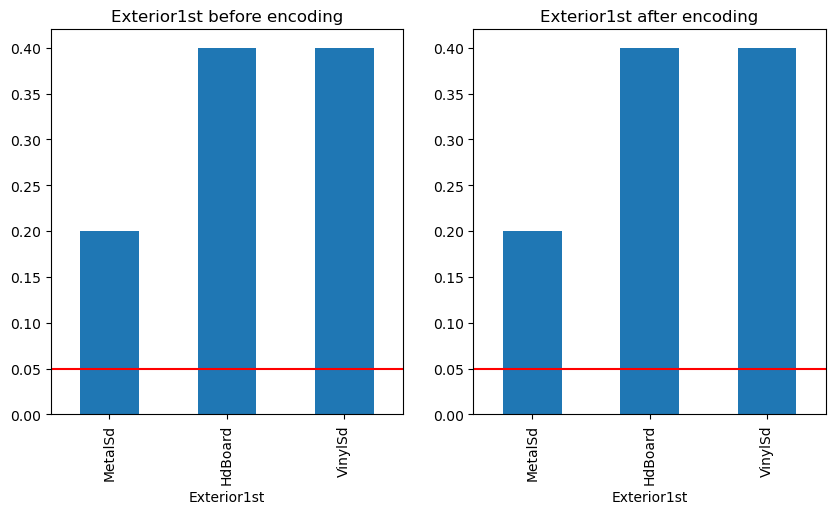

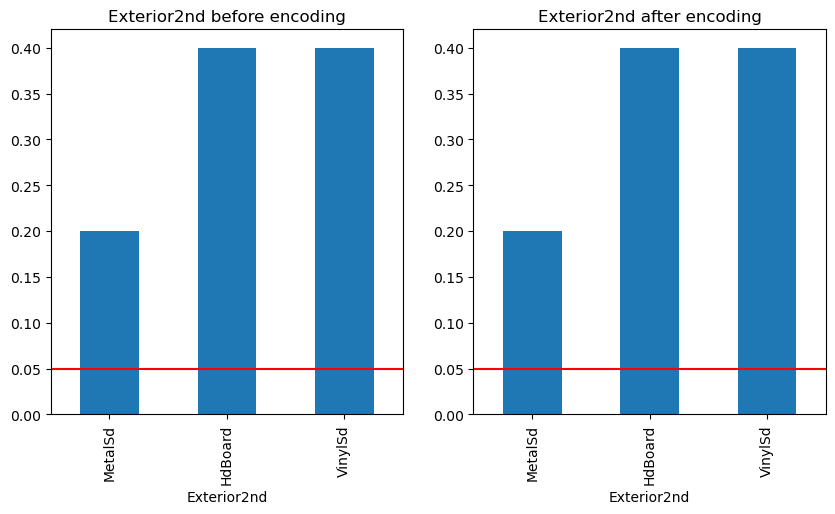

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Sample data
data = {
    'Neighborhood': ['OldTown', 'CollgCr', 'Somerst', 'NAmes', 'OldTown', 'CollgCr', 'Edwards', 'NAmes', 'Edwards', 'OldTown'],
    'Exterior1st': ['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'VinylSd', 'HdBoard', 'MetalSd', 'HdBoard', 'VinylSd'],
    'Exterior2nd': ['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'VinylSd', 'HdBoard', 'MetalSd', 'HdBoard', 'VinylSd'],
    'SalePrice': [200000, 250000, 190000, 300000, 210000, 230000, 180000, 320000, 190000, 215000]
}
df = pd.DataFrame(data)

# Separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['SalePrice']), df['SalePrice'], test_size=0.5, random_state=0)

# Function to replace rare categories with 'Rare'
def rare_encoding(df, variable, tolerance):
    freq = df[variable].value_counts(normalize=True)
    rare_categories = freq[freq < tolerance].index
    df[variable] = df[variable].apply(lambda x: 'Rare' if x in rare_categories else x)
    return df

# Apply rare encoding to the dataset
for variable in ['Neighborhood', 'Exterior1st', 'Exterior2nd']:
    X_train = rare_encoding(X_train, variable, 0.05)
    X_test = rare_encoding(X_test, variable, 0.05)

print("Engineering Rare Categories with Pandas:\n", X_train.head())

# Let's visualize the distribution of categories before and after rare encoding
for col in ['Neighborhood', 'Exterior1st', 'Exterior2nd']:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    X_train[col].value_counts(normalize=True).sort_values().plot.bar(ax=ax[0], title=f'{col} before encoding')
    X_train[col].value_counts(normalize=True).sort_values().plot.bar(ax=ax[1], title=f'{col} after encoding')
    ax[0].axhline(y=0.05, color='red')
    ax[1].axhline(y=0.05, color='red')
    plt.show()


This example ensures that rare categories are grouped correctly and visualizes the distribution of categories before and after the encoding. The threshold for considering a category as rare is set to 5% in this example